**<font size="80"> Final Project: EA Sports - FIFA </font>**

In [ ]:
#install beautifulsoup4
!pip install bs4==0.0.1

     |████████████████████████████████| 97 kB 6.5 MB/s 
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1272 sha256=f9b4a501be8413c09a896b14369d5949163471ef83759bd1c01452b458dc230c
  Stored in directory: /root/.cache/pip/wheels/0a/9e/ba/20e5bbc1afef3a491f0b3bb74d508f99403aabe76eda2167ca
Successfully built bs4
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
# import the necessary libraries for web scraping and EDA
import re
import requests
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from prettytable import PrettyTable
from sklearn.model_selection import cross_val_score
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from time import sleep
from bs4 import BeautifulSoup as bs

*<font size="50"> PART I - WEB SCRAPING </font>*

In [ ]:
def get_homepage_data(year_code):
    # initialize new lists to store the URLs of each players individual stats page
    player_urls = []
    player_names = []
    #initialize new lists to store big 6 attributes
    ids, paces, shots, passes, dribs, defs, phys = [], [], [], [], [], [], []
    pages = {150059: 275, 160058: 285, 170099: 294, 180084: 300, 190075: 301, 200061:327}

    for i in range(pages[year_code]):
        base_url = f'https://sofifa.com/players?showCol%5B0%5D=ae&showCol%5B1%5D=oa&showCol%5B2%5D=pt&showCol%5B3%5D=vl&showCol%5B4%5D=wg&showCol%5B5%5D=tt&showCol%5B6%5D=pac&showCol%5B7%5D=sho&showCol%5B8%5D=pas&showCol%5B9%5D=dri&showCol%5B10%5D=def&showCol%5B11%5D=phy&showCol%5B12%5D=pi&r={year_code}&set=true&offset={60*i}'
        home_page = requests.get(base_url)

        base_url2 = f"https://sofifa.com"

        # parse the home page with BeautifulSoup, saving it to the content variable
        soup = bs(home_page.content, "html.parser")

        #extract links from content by referencing their a tags and href attributes...
        #...and save those links as values in the player_urls dict
        links = soup.findAll('a', attrs={'href': re.compile("/player/")})
        for link in links:
            player_names.append(link.text)
            player_urls.append(base_url2 + link.get('href'))
        for sofid in soup.find_all("td", {"data-col": "pi"}):
            ids.append(int(sofid.text))
        for pace in soup.find_all("td", {"data-col": "pac"}):
            paces.append(int(pace.text))
        for shot in soup.find_all("td", {"data-col": "sho"}):
            shots.append(int(shot.text))
        for pas in soup.find_all("td", {"data-col": "pas"}):
            passes.append(int(pas.text))
        for drib in soup.find_all("td", {"data-col": "dri"}):
            dribs.append(int(drib.text))
        for defe in soup.find_all("td", {"data-col": "def"}):
            defs.append(int(defe.text))
        for phy in soup.find_all("td", {"data-col": "phy"}):
            phys.append(int(phy.text))

    player_data = pd.DataFrame(list(zip(player_names, player_urls)), columns =['Name', 'url'])    
    
    player_data["sofifa_id"] = ids
    player_data["Pace"] = paces
    player_data["Shooting"] = shots
    player_data["Passing"] = passes
    player_data["Dribbling"] = dribs
    player_data["Defending"] = defs
    player_data["Physical"] = phys
    player_data = player_data.drop_duplicates(subset = ['sofifa_id'])

    return player_data

In [ ]:
#GETS HOMEPAGE DATA FOR EACH YEAR AND REMOVES PLAYERS WHO WEREN'T PLAYING FOR ALL YEARS
def get_homepage_datasets(year_codes):
    homepage_datasets = {}
    ids_lists = []

    for code in year_codes:
        homepage_datasets[code] = get_homepage_data(code)
        ids_lists.append(list(homepage_datasets[code]["sofifa_id"]))

    shared = [sofifa_id for sofifa_id in ids_lists[0] if(sofifa_id in ids_lists[1] and sofifa_id in ids_lists[2] and sofifa_id in ids_lists[3] and sofifa_id in ids_lists[4] and sofifa_id in ids_lists[5])]    
    for code in year_codes:
        homepage_datasets[code] = homepage_datasets[code][homepage_datasets[code]["sofifa_id"].isin(shared)]

    return homepage_datasets

In [ ]:
#ACCESSES HTML AND STORES VALUES INTO PLAYER DATA DICTIONARY FOR A GIVEN YEAR
def get_year_data(homepage_data, code):
    player_dicts = []
    name_list = list(homepage_data.to_dict()["Name"].values())
    url_list = list(homepage_data.to_dict()["url"].values())
    for name, url in zip(name_list, url_list):
        player_dict = {} #make dictionary for each player

        raw_html = requests.get(url).content
        soup = bs(raw_html, 'html.parser')
        lis = soup.find_all("li", {"class": "ellipsis"})
        lis_len = len(lis)
        lis_off = 0
        

        if (lis[7].text[3].isnumeric()):
            lis_off = -1

        player_dict["sofifa_id"] = int(lis[8+lis_off].text[2:])
        player_dict["Name"] = name
        player_dict["URL"] = url

        divs = soup.find_all("div", {"class": "bp3-card player"})[0]
        divs2 = divs.find_all("div")

        player_dict['Age'] = int(divs2[1].text.split()[-6:][0][:2])
        player_dict['Date of Birth'] = divs2[1].text.split()[-6:][1][1:]+" "+divs2[1].text.split()[-6:][2]+" "+divs2[1].text.split()[-6:][3][:-1]
        player_dict['Height'] = int(divs2[1].text.split()[-6:][4][:-2])
        player_dict['Weight'] = int(divs2[1].text.split()[-6:][5][:-2])
        player_dict['Nationality'] = divs2[1].a["title"]

        nums = []
        quarters = soup.find_all("div", {"class": "block-quarter"})
        for i in range(2,4):
            text = quarters[i].text
            value = float(re.sub(r'[^.0-9]', '', text))
            scale = re.sub(r'[^M,K]', '', text)
            if scale == 'M':
                value = int(value*1000000)
            elif scale == "K":
                value = int(value*1000)
            nums.append(value)
        player_dict["Value"] = nums[0]
        player_dict["Wage"] = nums[1]

        quarters1 = quarters[6].find_all("li")
        quarters2 = quarters[7].find_all("li")
        if len(quarters1) >= len(quarters2):

            text = quarters1[2].text
            number = int(re.sub(r'[^0-9]', '', text))
            text1 = quarters1[1].text
            text2 = quarters1[3].text
            text3 = quarters1[4].text
            player_dict['Club'] = quarters[6].h5.text[1:]
            player_dict['Club Overall'] = int(quarters[6].span.text)
            player_dict['Club Kit Number'] = number
            player_dict['Club Position'] = text1[8:]
            if text2[-1:].isnumeric():
                player_dict['Joined'] = text2[6:]
            player_dict['Contract Valid Until'] = text3[-4:]

            text = quarters2[2].text
            number = int(re.sub(r'[^0-9]', '', text))
            text1 = quarters2[1].text
            if len(quarters) == 16:
                player_dict['National Team'] = quarters[7].h5.text[1:]
                player_dict['National Team Overall'] = int(quarters[7].span.text)
                player_dict['National Team Kit Number'] = number
                player_dict['National Team Position'] = text1[8:]
        
        else:
            text = quarters2[2].text
            number = int(re.sub(r'[^0-9]', '', text))
            text1 = quarters2[1].text
            text2 = quarters2[3].text
            text3 = quarters2[4].text
            if len(quarters) == 16:
                player_dict['Club'] = quarters[7].h5.text[1:]
                player_dict['Club Overall'] = int(quarters[7].span.text)
                player_dict['Club Kit Number'] = number
                player_dict['Club Position'] = text1[8:]
                if text2[-1:].isnumeric():
                    player_dict['Joined'] = text2[6:]
                player_dict['Contract Valid Until'] = text3[-4:]

            text = quarters1[2].text
            number = int(re.sub(r'[^0-9]', '', text))
            text1 = quarters1[1].text
            player_dict['National Team'] = quarters[6].h5.text[1:]
            player_dict['National Team Overall'] = int(quarters[6].span.text)
            player_dict['National Team Kit Number'] = number
            player_dict['National Team Position'] = text1[8:]

        
        player_dict["Preferred Foot"] = str(lis[0].text[14:])
        player_dict["Weak Foot"] = int(lis[1].text[0])
        player_dict["Skill Moves"] = int(lis[2].text[0])
        player_dict["International Reputation"] = int(lis[3].text[0])
        player_dict["Work Rate"] = lis[4].text[9:].replace(" ", "")
        player_dict["Body Type"] = lis[5].text[9:]
        player_dict["Real Face"] = lis[6].text[9:]
        if lis[7].text[3].isalpha():
            player_dict["Release Clause"] = lis[7].text[14:]
        
        specialties = []
        for i in range(9, lis_len-2):
            specialties.append(lis[i+lis_off].text.replace("\xa0", ""))
        player_dict["Specialties"] = specialties
        player_dict["Best Position"] = lis[lis_len-2].text[13:]

        spans = soup.find_all("span", {"class": "bp3-tag"})
        span_len = len(spans)
        spans2 = soup.find_all("span", {"class": "tooltip multiline"})
        player_dict["Overall Rating"] = int(spans[0].text)
        player_dict["Potential"] = int(spans[1].text)
        offset = 0 #offset if national team not in stats
        offset_comp = 0 #offset if composure not in stats

        if len(quarters) != 16:
            offset = -1 #set equal to negative one if no national team
            if span_len == 37:
                offset_comp = -1 #set composure offset to one if no national team and no compsure
        elif span_len == 38:
            offset_comp = -1 #set composure offset to one if national team and no composure
                
        for i in range(span_len-14-offset-offset_comp):
            player_dict[str(spans2[i].text)] = int(spans[i+4+offset].text)
        cutoff = span_len-15-offset-offset_comp
        if offset_comp == 0: 
            player_dict["Composure"] = int(spans[cutoff+offset+offset_comp+5].text)
        for j in range(cutoff+1,span_len-11-offset-offset_comp):
            player_dict[str(spans2[j].text)] = int(spans[j+5+offset+offset_comp].text)
        cutoff2 = span_len-12
        player_dict["GK Diving"] = int(spans[cutoff2+6].text)
        player_dict["GK Handling"] = int(spans[cutoff2+7].text)
        player_dict["GK Kicking"] = int(spans[cutoff2+8].text)
        player_dict["GK Positioning"] = int(spans[cutoff2+9].text)
        player_dict["GK Reflexes"] = int(spans[cutoff2+10].text)
        traits = []
        for i in range(cutoff2+1-offset,len(spans2)):
            traits.append(spans2[i].text)
        player_dict["Traits"] = traits

        divs3 = soup.find_all("div", {"class": "bp3-tag"})
        rtgs, poss = [],[]
        for div in divs3:
            text = div.text
            rtg = re.sub(r'[a-zA-Z]', '', text)
            rtg = re.sub(r'[^0-9]', ' ', rtg)
            rtgs1 = rtg.split()
            rtg = int(rtgs1[0]) + int(rtgs1[1])
            pos = re.sub(r'[^a-zA-Z]', '', text)
            rtgs.append(rtg)
            poss.append(pos)

        for i in range(len(rtgs)):
            player_dict[poss[i]] = rtgs[i]

        player_dicts.append(player_dict)

    year_data = pd.DataFrame(player_dicts)
    
    #rename defensive awareness or marking as defensive awareness / marking b/c name changed across time
    year_data.rename(columns={'Marking':'Defensive Awareness / Marking'}, inplace=True)
    year_data.rename(columns={'Defensive Awareness':'Defensive Awareness / Marking'}, inplace=True)

    #take columns for players big 6 attributes on homepage and put into dataset
    year_data["Pace/Diving"] = list(homepage_data["Pace"])
    year_data["Shooting/Handling"] = list(homepage_data["Shooting"])
    year_data["Passing/Kicking"] = list(homepage_data["Passing"])
    year_data["Dribbling/Reflexex"] = list(homepage_data["Dribbling"])
    year_data["Defending/Pace"] = list(homepage_data["Defending"])
    year_data["Physical/Positioning"] = list(homepage_data["Physical"])

    return(year_data)

In [ ]:
#MERGES EACH YEAR'S DATASETS TOGETHER TO GET ONE MAIN DATASET WITH "_year" TAGS ON EACH VARIABLE
def merge_datasets(year_datasets):
    #assign data to individual dataframes from list
    data15 = year_datasets[0]
    data16 = year_datasets[1]
    data17 = year_datasets[2]
    data18 = year_datasets[3]
    data19 = year_datasets[4]
    data20 = year_datasets[5]

    #merge dataframes
    #https://stackoverflow.com/questions/34338374/pandas-control-new-column-names-when-merging-two-dataframes
    merged1 = pd.merge(data16, data15, on="sofifa_id", suffixes=["_16", "_15"])
    merged2 = pd.merge(data18, data17, on="sofifa_id", suffixes=["_18", "_17"])
    merged3 = pd.merge(data20, data19, on="sofifa_id", suffixes=["_20", "_19"])
    merged4 = pd.merge(merged2, merged1, on="sofifa_id")
    data = pd.merge(merged3, merged4, on="sofifa_id")

    #no need for multiple name and date of birth categories so drop all but one
    data = data.drop(["Name_15", "Name_16", "Name_17", "Name_18", "Name_19"], axis=1)
    data.rename(columns={'Name_20':'Name'}, inplace=True)
    data = data.drop(["Date of Birth_15", "Date of Birth_16", "Date of Birth_17", "Date of Birth_18", "Date of Birth_19"], axis=1)
    data.rename(columns={'Date of Birth_20':'Date of Birth'}, inplace=True)

    data.to_csv('/work/player_data.csv', index=False)
    return data

In [ ]:
#LEAVE THIS CELL COMMENTED UNLESS WANT TO SCRAPE ALL DATA AGAIN ~3.5hrs
#UNCOMMENT TO RUN AND REWRITE 'PLAYER_DATA'.CSV FILE
'''#GET DATAFRAME FOR EACH YEAR BY CALLING ABOVE METHODS

year_codes = [150059, 160058, 170099, 180084, 190075, 200061]
#[150059, 160058, 170099, 180084, 190075, 200061]

year_datasets = [] #list of datasets returned from get_year_data -- will be merged together to create our main dataset

#dictionary storing each homepage data inlcuding url links to players' pages for that year
#each homepage_dataset is filtered to only include names that were around from 2015-2020
homepage_datasets = get_homepage_datasets(year_codes) 

#go through each year and call get_year_data to store 
for code in year_codes:
    year_datasets.append(get_year_data(homepage_datasets[code], code))

data = merge_datasets(year_datasets)
data.head()'''

"#GET DATAFRAME FOR EACH YEAR BY CALLING ABOVE METHODS\n\nyear_codes = [150059, 160058, 170099, 180084, 190075, 200061]\n#[150059, 160058, 170099, 180084, 190075, 200061]\n\nyear_datasets = [] #list of datasets returned from get_year_data -- will be merged together to create our main dataset\n\n#dictionary storing each homepage data inlcuding url links to players' pages for that year\n#each homepage_dataset is filtered to only include names that were around from 2015-2020\nhomepage_datasets = get_homepage_datasets(year_codes) \n\n#go through each year and call get_year_data to store \nfor code in year_codes:\n    year_datasets.append(get_year_data(homepage_datasets[code], code))\n\ndata = merge_datasets(year_datasets)\ndata.head()"

In [ ]:
def get_teams(code):
    offsets = [0, 60]
    clubs = []
    leagues = []

    for offset in offsets:
        url = f"https://sofifa.com/teams?type=all&lg%5B0%5D=13&lg%5B1%5D=16&lg%5B2%5D=19&lg%5B3%5D=31&lg%5B4%5D=53&r={code}&set=true&offset={offset}"
        homepage = requests.get(url)
        soup = bs(homepage.content, "html.parser") 
        links = soup.findAll('a', attrs={'href': re.compile("/team/")})
        for link in links:
            clubs.append(link.text)

        links2 = soup.findAll('a', attrs={'href': re.compile("/teams?"), 'rel': 'nofollow', 'class': 'sub'})
        for link in links2:
            leagues.append(str(link.text)[:-4])

    team_df = pd.DataFrame(list(zip(clubs, leagues)), columns =['Club Name', 'League'])
    return(team_df)

In [ ]:
#CELL FOR SCRAPING TEAMS/LEAGUES DATA
#UNCOMMENT TO RUN AND REWRITE TEAM_DATA CSV FILES
'''get_teams(150059).to_csv('/work/team_data_15.csv', index=False)
get_teams(200061).to_csv('/work/team_data_20.csv', index=False)'''

"get_teams(150059).to_csv('/work/team_data_15.csv', index=False)\nget_teams(200061).to_csv('/work/team_data_20.csv', index=False)"

*<font size="50"> Part II - EDA / DATA CLEANING </font>*

In [ ]:
# read the scraped data from player_data.csv
df = pd.read_csv("player_data.csv")
df.shape

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3173: DtypeWarning: Columns (16,19,113,116,306,307,310,497) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(5173, 581)

In [ ]:
df.drop(df.index[df['Contract Valid Until_15'] == 'eys\n'], inplace=True) #drop row for player with no national team or club team
df.astype({'Contract Valid Until_15': 'float'}, copy=False).head() # take a quick look at the data

,sofifa_id,Name,URL_20,Age_20,Date of Birth,Height_20,Weight_20,Nationality_20,Value_20,Wage_20,...,RCB_15,RB_15,GK_15,Composure,Pace/Diving_15,Shooting/Handling_15,Passing/Kicking_15,Dribbling/Reflexex_15,Defending/Pace_15,Physical/Positioning_15
0,158023,L. Messi,https://sofifa.com/player/158023/lionel-messi/...,32,"Jun 24, 1987",170,72,Argentina,95500000.0,560000.0,...,48,57,18,NaN,93,88,86,96,27,63
1,20801,Cristiano Ronaldo,https://sofifa.com/player/20801/c-ronaldo-dos-...,34,"Feb 5, 1985",187,83,Portugal,58500000.0,410000.0,...,55,60,19,NaN,93,93,81,91,32,79
2,190871,Neymar Jr,https://sofifa.com/player/190871/neymar-da-sil...,27,"Feb 5, 1992",175,68,Brazil,105500000.0,290000.0,...,48,58,19,NaN,90,80,72,92,30,58
3,203376,V. van Dijk,https://sofifa.com/player/203376/virgil-van-di...,27,"Jul 8, 1991",193,92,Netherlands,90000000.0,240000.0,...,75,71,14,NaN,71,59,64,66,75,83
4,200389,J. Oblak,https://sofifa.com/player/200389/jan-oblak/200...,26,"Jan 7, 1993",188,87,Slovenia,77500000.0,125000.0,...,36,33,77,NaN,74,83,67,77,52,79


In [ ]:
# get descriptive statistics for the data
df.describe()

,sofifa_id,Age_20,Height_20,Weight_20,Value_20,Wage_20,Club Overall_20,Club Kit Number_20,Contract Valid Until_20,National Team Overall_20,...,RCB_15,RB_15,GK_15,Composure,Pace/Diving_15,Shooting/Handling_15,Passing/Kicking_15,Dribbling/Reflexex_15,Defending/Pace_15,Physical/Positioning_15
count,5172.000000,5172.000000,5172.000000,5172.000000,5.172000e+03,5172.000000,5139.000000,5139.000000,5139.000000,585.000000,...,5172.000000,5172.000000,5172.000000,0.0,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.00000
mean,197817.111949,28.043890,181.884764,76.607115,5.027635e+06,20667.691415,71.197898,16.895310,2021.207239,77.478632,...,54.118329,54.771655,19.067285,NaN,71.147912,54.408159,58.572699,64.159319,51.433101,66.04273
std,25640.569326,3.598035,6.700824,7.026646,8.794327e+06,34478.396234,5.384762,14.828825,1.238437,4.665155,...,13.471039,13.009445,17.074991,NaN,9.611340,13.942775,10.577793,10.739858,15.890616,9.41326
min,41.000000,20.000000,158.000000,57.000000,0.000000e+00,0.000000,56.000000,1.000000,2019.000000,65.000000,...,25.000000,26.000000,5.000000,NaN,31.000000,23.000000,24.000000,28.000000,22.000000,28.00000
25%,188370.250000,25.000000,177.000000,72.000000,6.750000e+05,4000.000000,67.000000,7.000000,2020.000000,74.000000,...,43.000000,46.000000,12.000000,NaN,65.000000,44.000000,52.000000,58.000000,36.000000,60.00000
50%,202410.500000,28.000000,182.000000,76.000000,1.900000e+06,9000.000000,70.000000,14.000000,2021.000000,77.000000,...,56.000000,57.000000,13.000000,NaN,71.000000,57.000000,59.000000,65.000000,54.000000,67.00000
75%,214001.750000,31.000000,187.000000,81.000000,6.000000e+06,24000.000000,75.000000,23.000000,2022.000000,82.000000,...,65.000000,65.000000,15.000000,NaN,78.000000,65.000000,66.000000,71.000000,65.000000,73.00000
max,230977.000000,41.000000,203.000000,110.000000,1.055000e+08,560000.000000,86.000000,99.000000,2028.000000,85.000000,...,87.000000,86.000000,90.000000,NaN,97.000000,93.000000,91.000000,96.000000,89.000000,90.00000


<font size="6"> Exploratory Data Analysis for Part A: Rank the Players </font>

Text(0, 0.5, 'Overall Rating in 2019')

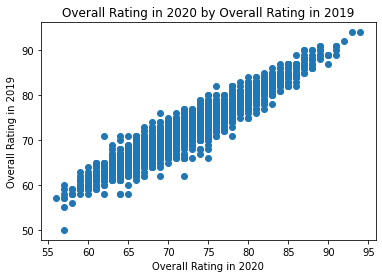

In [ ]:
# Overall rating in 2020 based on overall rating in 2019

x = df['Overall Rating_20']
y = df['Overall Rating_19']

plt.scatter(x, y)
plt.title('Overall Rating in 2020 by Overall Rating in 2019')
plt.xlabel('Overall Rating in 2020')
plt.ylabel('Overall Rating in 2019')

Text(0, 0.5, 'Player Wage')

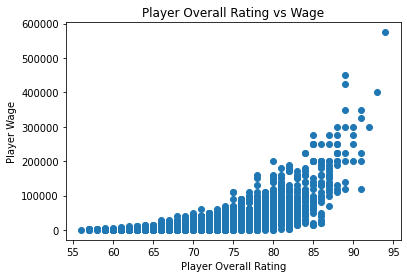

In [ ]:
# scatterplot of overall rating vs wage

x = df['Overall Rating_20']
y = df['Wage_19']

plt.scatter(x, y)
plt.title('Player Overall Rating vs Wage')
plt.xlabel('Player Overall Rating')
plt.ylabel('Player Wage')

<font size="6"> Exploratory Data Analysis for Part B: Classifying Player Positions </font>

In [ ]:
# comparing average skill values across different positions (individual graphs are in the next cell)

importantdf = df[['Best Position_20', 'Dribbling/Reflexex_20', 'Pace/Diving_20', 'Shooting/Handling_20', 'Passing/Kicking_20', 'Defending/Pace_20', 'Physical/Positioning_20']].copy()

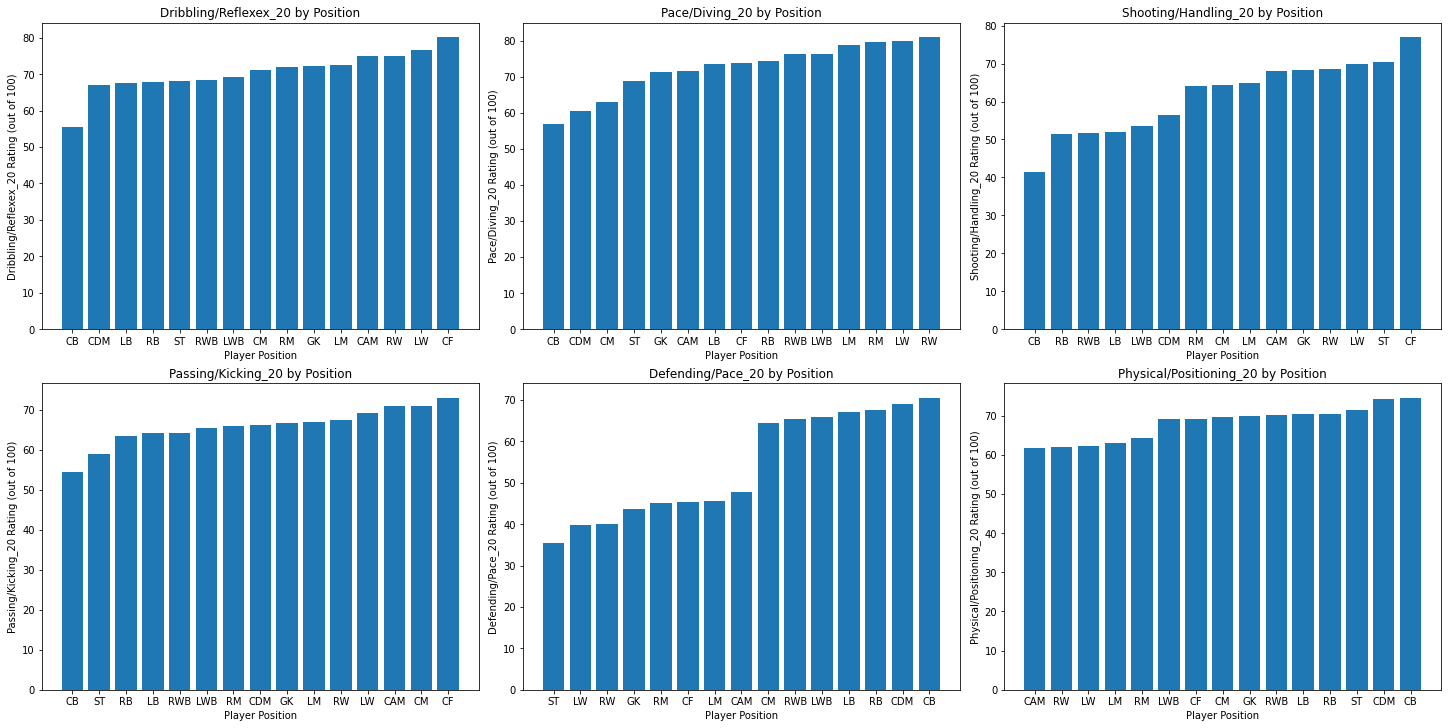

In [ ]:
# the same graph as above, but separating it out into 6 graphs by skill categories
# NOTE: Each stat has a different meaning for GKs, which comes after the / in the title

position_stats = importantdf.groupby('Best Position_20').aggregate('mean')
columnlist = ['Dribbling/Reflexex_20', 'Pace/Diving_20', 'Shooting/Handling_20', 'Passing/Kicking_20', 'Defending/Pace_20', 'Physical/Positioning_20']

fig, axs = plt.subplots(2,3,constrained_layout=True,figsize=(20,10))

for i in range(len(columnlist)):
    name = columnlist[i]
    temp = position_stats[name]
    tempdf = temp.to_frame()
    tempdfsorted = tempdf.sort_values(name)
    index = tempdfsorted.index
    rownames = list(index)
    x = rownames
    y = tempdfsorted[name]
    axs[int(i/3)][i%3].bar(x, y)
    axs[int(i/3)][i%3].set_title(f'{name} by Position')
    axs[int(i/3)][i%3].set_xlabel('Player Position')
    axs[int(i/3)][i%3].set_ylabel(f'{name} Rating (out of 100)')
plt.show()

<font size="6"> Exploratory Data Analysis for Part C: Club with the Best Staff </font>

Text(0, 0.5, 'Overall Club Improvement')

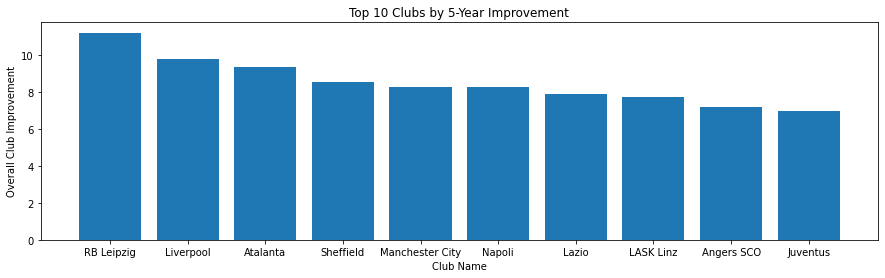

In [ ]:
# graph the above
teamdf = df[['Club_20', 'Club Overall_20', 'Club Overall_15']].copy()

cluboverall = teamdf.groupby('Club_20').aggregate('mean')
cluboverall['change'] = cluboverall['Club Overall_20'] - cluboverall['Club Overall_15']
cluboverallsorted = cluboverall.sort_values(by = ['change'], ascending = False)

index = cluboverallsorted.index
clubs = list(index)
clubs[3] = 'Sheffield'

x = clubs[:10]
y = cluboverallsorted['change'].head(10)
plt.figure(figsize=(15,4))
plt.bar(x, y)
plt.title('Top 10 Clubs by 5-Year Improvement')
plt.xlabel("Club Name")
plt.ylabel("Overall Club Improvement")

<font size="6"> Exploratory Data Analysis for Part D: How Things Will Be in 2021 </font>

Text(0, 0.5, 'Average Overall Rating Improvement')

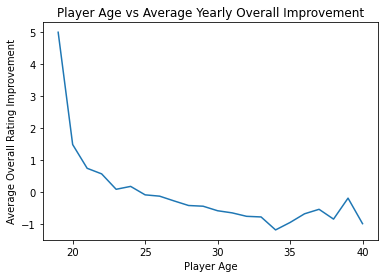

In [ ]:
# Overall Improvement by Age (can be used to predict player's overall ratings the following year)
df2 = df.copy()
df2["improvement1920"] = df2['Overall Rating_20'] - df2['Overall Rating_19']
databy2019age = df2.groupby('Age_19').aggregate('mean')

plt.plot(databy2019age['improvement1920'])
plt.title('Player Age vs Average Yearly Overall Improvement')
plt.xlabel('Player Age')
plt.ylabel('Average Overall Rating Improvement')

*<font size="80"> Part III: Modeling </font>*

<font size="6"> Part A: Rank the Players </font>

In [ ]:
 #PART A
dfA = df.copy()
dfA["Best Position_20"] = dfA["Best Position_19"] #set position in 20 to position in 19 if changed
dfA["Best Position_19"] = dfA["Best Position_18"] #set position in 19 to position in 18 if changed

cols = list(dfA.columns)

cols_18 = [col for col in cols if "18" in col]
cols_19 = [col for col in cols if "19" in col]
columns = cols_18 + cols_19
columns.append('Overall Rating_20')

dfA = dfA[columns]
dfA = dfA.drop(["URL_18", "Potential_18", "Real Face_18","URL_19", "Potential_19", "Real Face_19"], axis=1)


In [ ]:
train_columns = cols_18 + ['Overall Rating_19']
train_columns.remove('Overall Rating_18')
train_columns.remove('Real Face_18')
train_columns.remove('Potential_18')
train_columns.remove('URL_18')
train_data = dfA[train_columns]

newtraincolnames = {}
for col in train_columns:
    newtraincolnames[col] = col[:-3]

#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html
train_data = train_data.rename(columns = newtraincolnames)
train_data.drop(["National Team Overall","National Team Kit Number","Nationality","Joined","National Team Position","Club","Specialties","Traits"], axis=1, inplace = True)
train_data['Right Footed'] =1*(train_data['Preferred Foot'] == 'Right')
train_data = train_data.drop(['Preferred Foot'], axis = 1)
dums = pd.get_dummies(train_data["Best Position"])
train_data = train_data.join(dums, rsuffix = 'Best Pos')
dums1 = pd.get_dummies(train_data["Body Type"])
train_data = train_data.join(dums1)
dums2 = pd.get_dummies(train_data["Work Rate"])
train_data = train_data.join(dums2)
train_data['On National Team'] = 1*(~train_data['National Team'].isna())

In [ ]:
test_clubs = ["FC Barcelona", "FC Bayern München", "Real Madrid", "Paris Saint-Germain", "Juventus", "Manchester City", "Liverpool FC"]
test_data = dfA[dfA["Club_19"].isin(test_clubs)]

test_columns = cols_19 + ['Overall Rating_20']
test_columns.remove('Overall Rating_19')
test_columns.remove('Real Face_19')
test_columns.remove('Potential_19')
test_columns.remove('URL_19')
test_columns.remove('Release Clause_19')
test_data = test_data[test_columns]

newtestcolnames = {}
for col in test_columns:
    newtestcolnames[col] = col[:-3]

#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html
test_data = test_data.rename(columns = newtestcolnames)
test_data.drop(["National Team Overall","National Team Kit Number","Nationality","Joined","National Team Position","Club","Specialties","Traits"], axis=1, inplace = True)
test_data['Right Footed'] =1*(test_data['Preferred Foot'] == 'Right')
test_data = test_data.drop(['Preferred Foot'], axis = 1)
dums = pd.get_dummies(train_data["Best Position"])
test_data = test_data.join(dums, rsuffix = 'Best Pos')
dums1 = pd.get_dummies(train_data["Body Type"])
test_data = test_data.join(dums1)
dums2 = pd.get_dummies(train_data["Work Rate"])
test_data = test_data.join(dums2)
test_data['On National Team'] = 1*(~test_data['National Team'].isna())

train_data.drop(['National Team', 'Best Position', 'Body Type', 'Work Rate', 'Club Position'], axis = 1, inplace = True)
test_data.drop(['National Team', 'Best Position', 'Body Type', 'Work Rate', 'Club Position'], axis = 1, inplace = True)
train_data.dropna(axis = 0, inplace = True)

In [ ]:
X_trainA = train_data.drop('Overall Rating', axis = 1)
y_trainA = train_data['Overall Rating']

X_testA = test_data.drop('Overall Rating', axis = 1)
y_testA = test_data['Overall Rating']

In [ ]:
#cross validate to hypertune tree depth
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
trainmsesA, valmsesA = [], []

for i in range(25):
    mse = cross_validate(DecisionTreeRegressor(max_depth = i + 1), X_trainA, y_trainA, cv = 10, scoring = 'neg_mean_squared_error',return_train_score = True)
    trainmsesA.append(-1* np.mean(mse['train_score']))
    valmsesA.append(-1* np.mean(mse['test_score']))


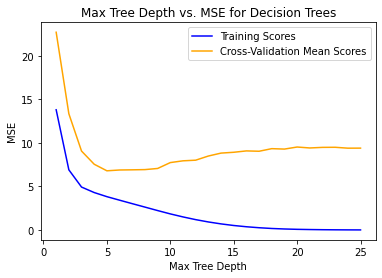

In [ ]:
depthslist = [i + 1 for i in range(25)]
plt.plot(depthslist,trainmsesA,color='blue',label="Training Scores")
plt.plot(depthslist,valmsesA,color='orange',label="Cross-Validation Mean Scores")
plt.title("Max Tree Depth vs. MSE for Decision Trees")
plt.xlabel("Max Tree Depth")
plt.ylabel("MSE")
plt.legend(loc='upper right')

In [ ]:
print(valmsesA)

[22.70190147224286, 13.34342498962026, 9.05945990761564, 7.545186443659769, 6.7922297266367835, 6.88547916209122, 6.905067251233864, 6.9299579521779915, 7.060543291636975, 7.7356469798774965, 7.9382850785101216, 8.01145023971282, 8.488683466113663, 8.825243307441625, 8.919691142019694, 9.076594067736888, 9.03761724528658, 9.335465344916658, 9.286799469562098, 9.522704541048366, 9.414847136792787, 9.482206446745622, 9.49337344968288, 9.390934026961126, 9.395506981543061]


In [ ]:
treeA = DecisionTreeRegressor(max_depth = 5)
treeA.fit(X_trainA,y_trainA)
y_predA = treeA.predict(X_testA)
y_pred_trainA = treeA.predict(X_trainA)
msetreeA_train = mean_squared_error(y_pred_trainA,y_trainA)
msetreeA_test = mean_squared_error(y_predA,y_testA)

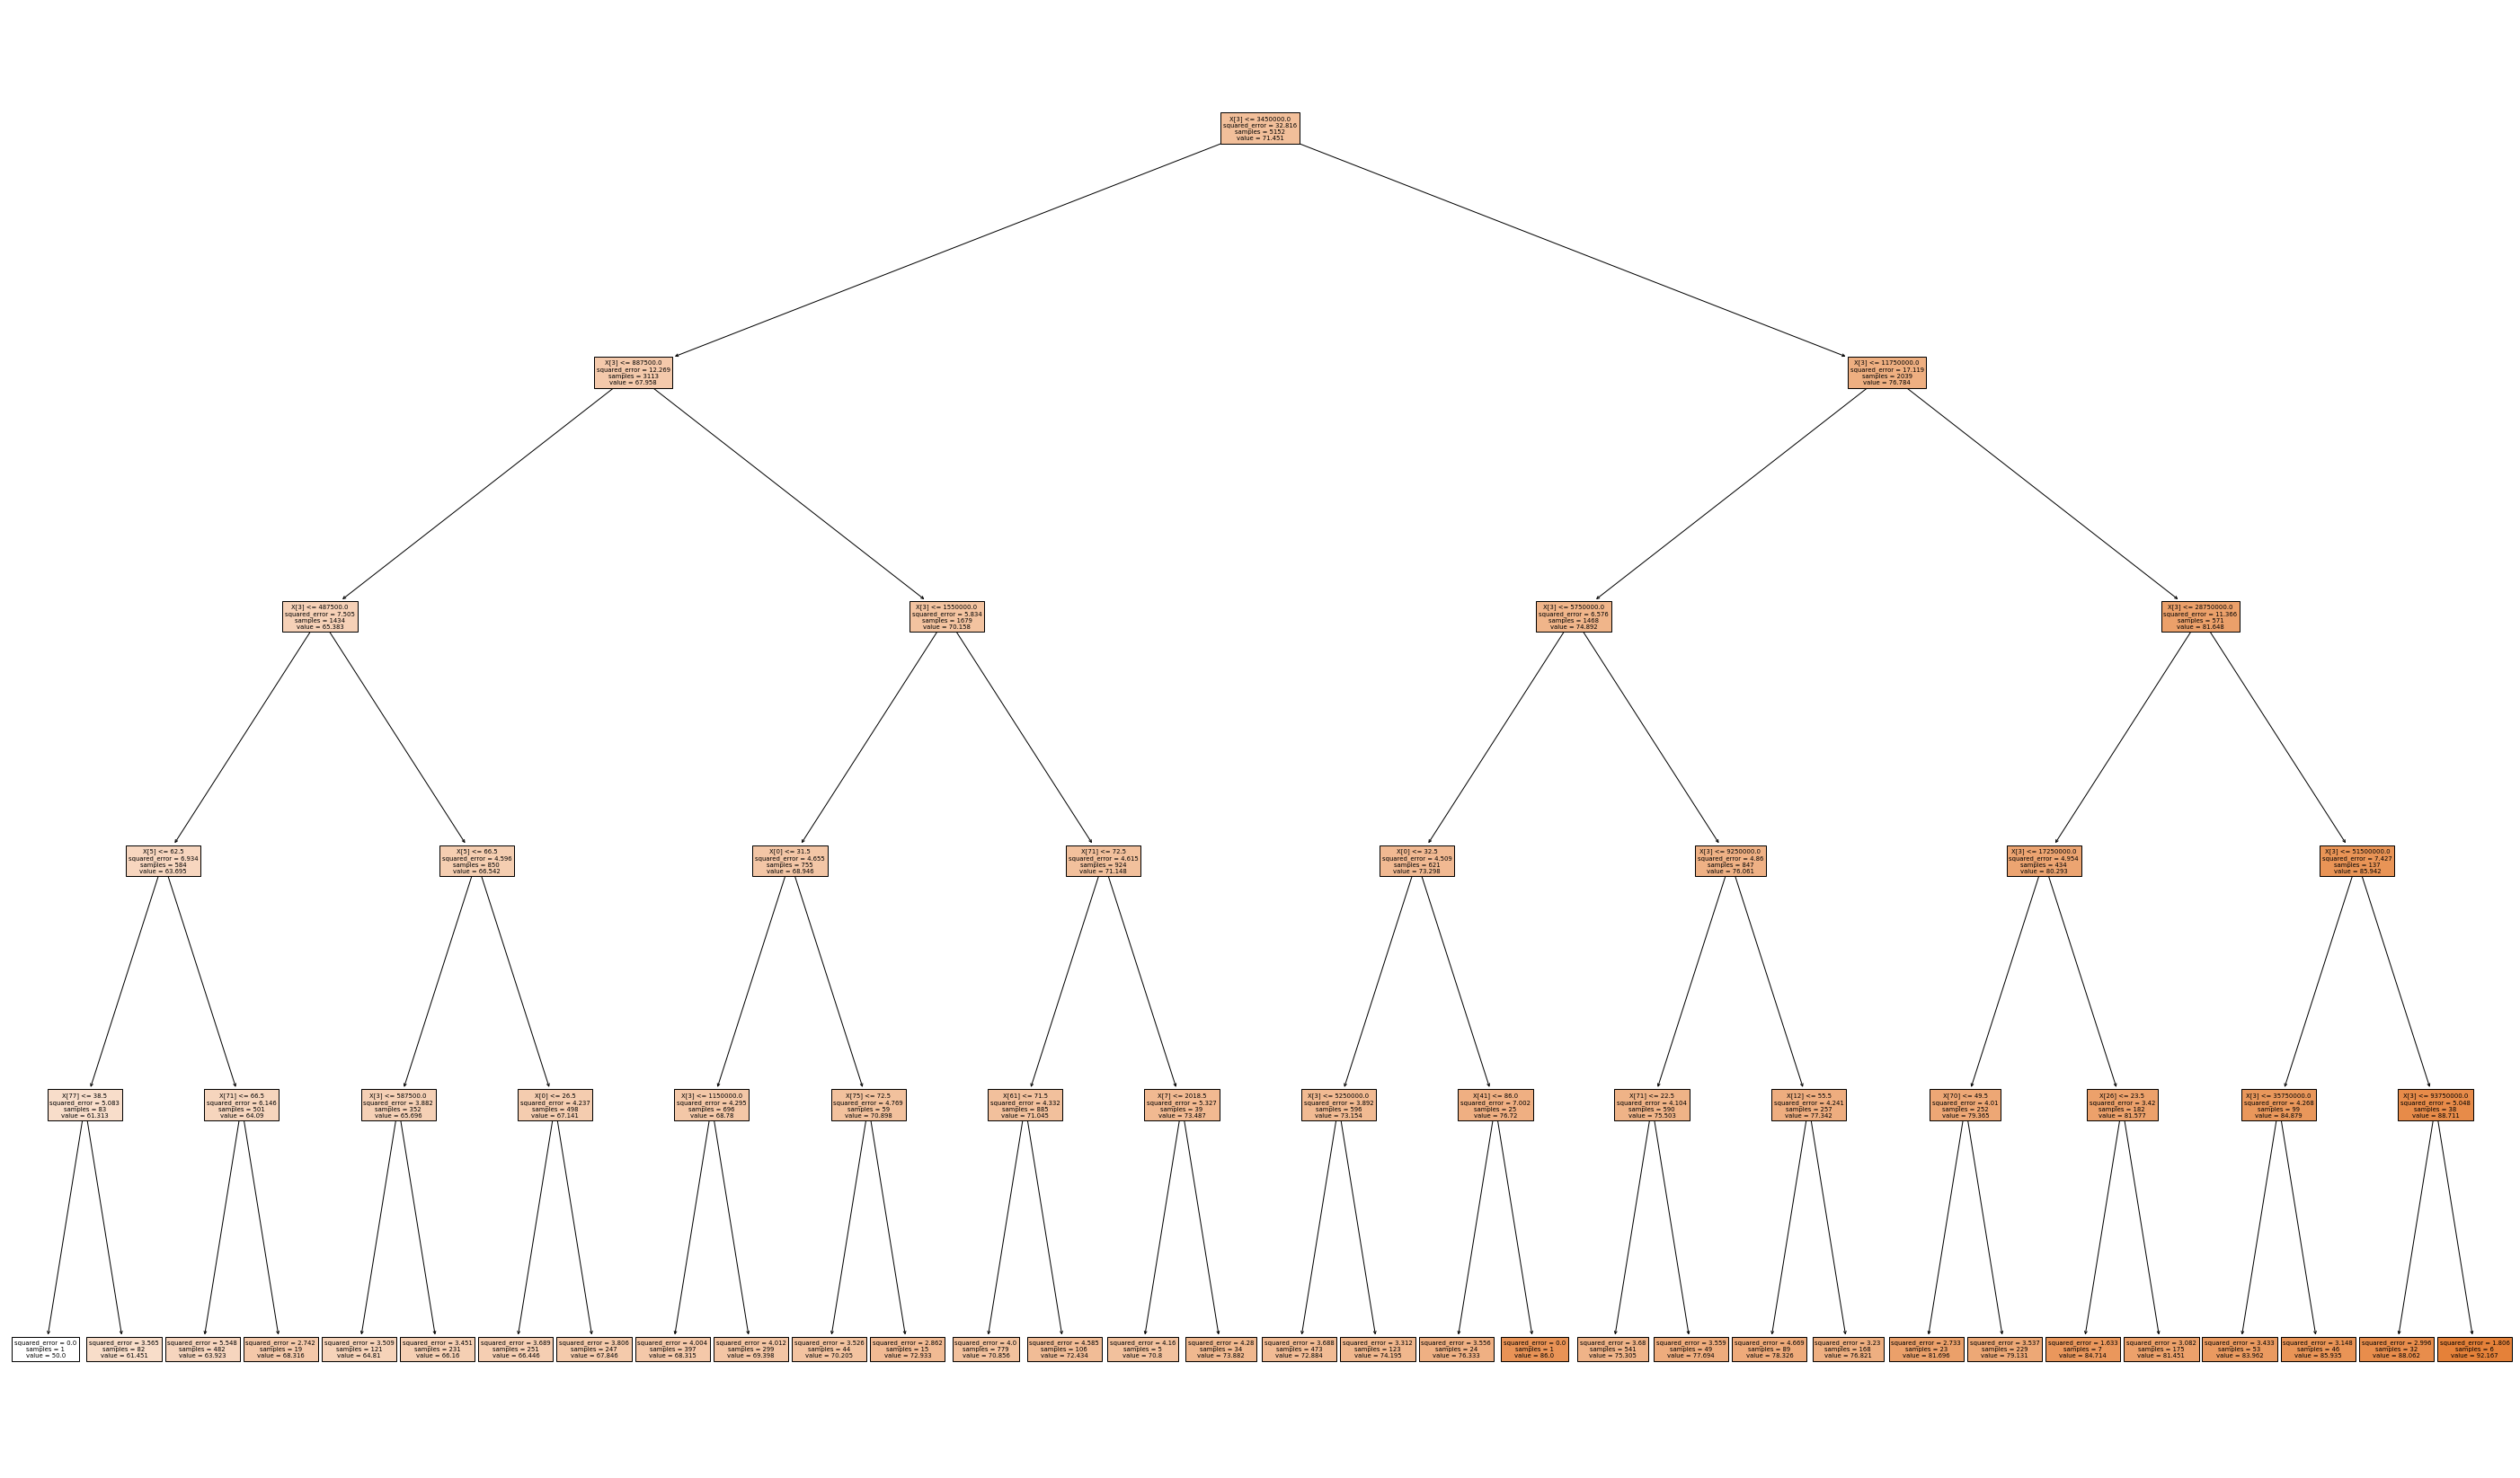

In [ ]:
plt.figure(figsize=(50,30))
plot_tree(treeA, filled = True)
plt.show();


In [ ]:
treeA.feature_importances_

array([5.32283218e-03, 0.00000000e+00, 0.00000000e+00, 9.76366160e-01,
       0.00000000e+00, 6.57274470e-03, 0.00000000e+00, 2.77966142e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       8.83779298e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 4.80954148e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 6.02098540e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [ ]:
#bagging
bagmodel = BaggingRegressor(base_estimator = DecisionTreeRegressor(max_depth = 5), n_estimators = 30)
bagmodel.fit(X_trainA, y_trainA)
y_predABag = bagmodel.predict(X_testA)
y_predABag_train = bagmodel.predict(X_trainA)
msebagA_test = mean_squared_error(y_predABag, y_testA)
msebagA_train = mean_squared_error(y_predABag_train,y_trainA)

In [ ]:
# Random Forest
# hypertune number of trees
randomforestA = RandomForestRegressor(n_estimators = 30, max_depth=5, max_features='sqrt')
randomforestA.fit(X_trainA, y_trainA)
y_predAforest = randomforestA.predict(X_testA)
y_predAforest_train = randomforestA.predict(X_trainA)
mseforestA_test = mean_squared_error(y_predAforest,y_testA)
mseforestA_train = mean_squared_error(y_predAforest_train,y_trainA)

In [ ]:
pt = PrettyTable()
pt.field_names = ['Model Type', 'Train MSE', 'Test MSE']
pt.add_row(['Single Decision Tree', round(msetreeA_train, 4), round(msetreeA_test,4)])
pt.add_row(['Bagging', round(msebagA_train,4), round(msebagA_test,4)])
pt.add_row(['Random Forest', round(mseforestA_test,4), round(mseforestA_test,4)])
print(pt)

+----------------------+-----------+----------+
|      Model Type      | Train MSE | Test MSE |
+----------------------+-----------+----------+
| Single Decision Tree |   3.8975  |  4.618   |
|       Bagging        |   3.4949  |  3.5071  |
|    Random Forest     |   3.4051  |  3.4051  |
+----------------------+-----------+----------+


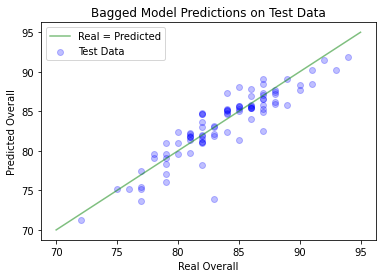

In [ ]:
# prediction graph
#y_testA_correct = y_testA[y_testA == y_predABag]
#y_testA_incorrect = y_testA[y_testA != y_predABag]
#y_predA_correct = y_predABag[y_testA == y_predABag]
#y_predA_incorrect = y_predABag[y_testA != y_predABag]

plt.scatter(y_testA, y_predABag, color='b', alpha = .25, label = 'Test Data')
x= np.linspace(70,95, 300)
y=x
plt.plot(x,y,color='g',alpha=.5, label = 'Real = Predicted')
plt.xlabel('Real Overall')
plt.ylabel('Predicted Overall')
plt.title('Bagged Model Predictions on Test Data')
plt.legend()
plt.show()

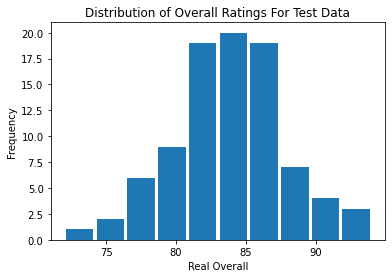

In [ ]:
plt.hist(y_testA, rwidth=0.9)
plt.xlabel('Real Overall')
plt.ylabel('Frequency')
plt.title('Distribution of Overall Ratings For Test Data')
plt.show()

<font size="6"> Part B: Classify Player Position </font>

In [ ]:
df2 = pd.read_csv('player_data.csv')

# create the dataframe for y_train
df3 = pd.DataFrame()
df3['position'] = df2['Best Position_19']

# process the data and create the dataframe for x_train
predictors = ['Preferred Foot_19',
'Weak Foot_19',
 'Skill Moves_19',
 'Potential_19',
 'Crossing_19',
 'Finishing_19',
 'Heading Accuracy_19',
 'Short Passing_19',
 'Volleys_19',
 'Dribbling_19',
 'Curve_19',
 'FK Accuracy_19',
 'Long Passing_19',
 'Ball Control_19',
 'Acceleration_19',
 'Sprint Speed_19',
 'Agility_19',
 'Reactions_19',
 'Balance_19',
 'Shot Power_19',
 'Jumping_19',
 'Stamina_19',
 'Strength_19',
 'Long Shots_19',
 'Aggression_19',
 'Interceptions_19',
 'Positioning_19',
 'Vision_19',
 'Penalties_19',
 'Composure_19',
 'Defensive Awareness / Marking_19',
 'Standing Tackle_19',
 'Sliding Tackle_19',
 'GK Diving_19',
 'GK Handling_19',
 'GK Kicking_19',
 'GK Positioning_19',
 'GK Reflexes_19',
 'Pace/Diving_19',
 'Shooting/Handling_19',
 'Passing/Kicking_19',
 'Dribbling/Reflexex_19',
 'Defending/Pace_19',
 'Physical/Positioning_19']
dfB = pd.DataFrame()
for predictor in predictors:
    dfB[predictor] = df2[predictor]

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3173: DtypeWarning: Columns (16,19,113,116,306,307,310,497) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# create binary columns for the preferred foot variable
dum = pd.get_dummies(dfB['Preferred Foot_19'])
dfB = pd.concat([dfB, dum], axis=1, join="inner")
dfB = dfB.drop('Preferred Foot_19', 1)
dfB = dfB.drop('Weak Foot_19', 1)

In [ ]:
for column in dfB.columns:
    dfB.rename(columns = {column:column[:-3]}, inplace = True)

# dfB.head(3)

In [ ]:
# specify x_train and y_train
x_train = dfB
y_train = df3

In [ ]:
# process the data for x_test and y_test
testpredictors = []
for predictor in predictors:
    testpredictors.append(predictor[:(len(predictor)-2)] + '20')

test_clubsB = ["FC Barcelona", "FC Bayern München", "Real Madrid", "Paris Saint-Germain", "Juventus", "Manchester City", "Liverpool FC", "Manchester United", "Atlético de Madrid"]
x_test = pd.DataFrame()
df2_1 = df2[df2['Club_20'].isin(test_clubsB)]
for predictor in testpredictors:
    x_test[predictor] = df2_1[predictor]

dum = pd.get_dummies(x_test['Preferred Foot_20'])
x_test = pd.concat([x_test, dum], axis=1, join="inner")
x_test = x_test.drop('Preferred Foot_20', 1)
x_test = x_test.drop('Weak Foot_20', 1)

for column in x_test.columns:
    x_test.rename(columns = {column:column[:-3]}, inplace = True)

# specify y_test
y_test = df2_1['Best Position_20']

In [ ]:
crossvalscoresB = []

for i in range(25):
    cv = cross_val_score(DecisionTreeClassifier(max_depth = i + 1), x_train, y_train, cv = 10)
    crossvalscoresB.append(np.mean(cv))

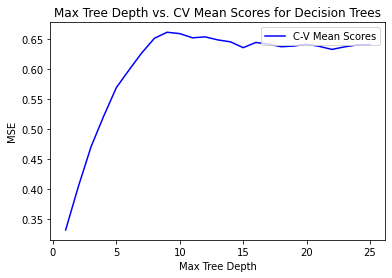

In [ ]:
depthslist = [i + 1 for i in range(25)]
plt.plot(depthslist,crossvalscoresB,color='blue',label="C-V Mean Scores")
plt.title("Max Tree Depth vs. CV Mean Scores for Decision Trees")
plt.xlabel("Max Tree Depth")
plt.ylabel("MSE")
plt.legend(loc='upper right')

In [ ]:
print(crossvalscoresB)

[0.33191564042627875, 0.40422619358789563, 0.47052418541780244, 0.5217493260046452, 0.5692994182355884, 0.598695324227239, 0.6271132834962623, 0.6514674801908844, 0.6615157987498412, 0.6591965826008379, 0.6522370671306842, 0.6537825888889719, 0.6487588030141223, 0.6454698550443232, 0.6358042762298082, 0.6444986296050126, 0.6416006362814874, 0.637345317132551, 0.6385058587186248, 0.6416025033046309, 0.6379311889950188, 0.6329003084322233, 0.6371560009857882, 0.6404382276722702, 0.6410207388930794]


In [ ]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
from prettytable import PrettyTable

# Initialize a Decision Tree classifier with a depth of 10
dtreeB = DecisionTreeClassifier(max_depth=10)
# Fit the classifier on the train data
dtreeB.fit(x_train, y_train)

# Compute the train and test accuracy for decision tree classifiers
dtreeB_train_acc = dtreeB.score(x_train, y_train)
dtreeB_test_acc = dtreeB.score(x_test, y_test)
print(dtreeB_train_acc)
print(dtreeB_test_acc)

0.8420645660158516
0.648


In [ ]:
print(dtreeB.feature_importances_)

[0.00201568 0.00074312 0.03096379 0.02880397 0.13433015 0.00763109
 0.00428219 0.01054478 0.00129882 0.00578009 0.03703184 0.00663481
 0.01690148 0.01925981 0.01081721 0.00087676 0.00453881 0.00101897
 0.00370487 0.01163538 0.01196266 0.00463576 0.01069826 0.00872162
 0.15639125 0.03726248 0.00138312 0.00092082 0.00544713 0.08260915
 0.01072913 0.00046526 0.0017535  0.00280469 0.00333182 0.16966353
 0.03390875 0.00447843 0.01375033 0.01821056 0.02437856 0.01425079
 0.00699422 0.03643457]


In [ ]:
# Random Forest
# initalize the model and fit it to the training data
randomforest = RandomForestClassifier(n_estimators = 30, max_depth=10, max_features='sqrt')
randomforest.fit(x_train, y_train)

# calculate the train and test accuracy score
random_forest_train_score = randomforest.score(x_train, y_train)
random_forest_test_score = randomforest.score(x_test, y_test)

y_pred_forest = randomforest.predict(x_test)

print('Training accuracy is ' + str(round(random_forest_train_score, 4)))
print('Test accuracy is ' + str(round(random_forest_test_score, 4)))

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
Training accuracy is 0.9287
Test accuracy is 0.744


In [ ]:
#https://vitalflux.com/bagging-classifier-python-code-example/
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier

pipeline = make_pipeline(StandardScaler(), LogisticRegression(random_state=1))
bgclassifier = BaggingClassifier(base_estimator=pipeline, n_estimators=100, max_features=10, max_samples=100, random_state=1, n_jobs=5)

# Fit the bagging classifier

bgclassifier.fit(x_train, y_train)

print('Model test Score is %.3f, ' %bgclassifier.score(x_test, y_test),
      'Model training Score is %.3f' %bgclassifier.score(x_train, y_train))

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/ensemble/_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
Model test Score is 0.656,  Model training Score is 0.666


In [ ]:
pt = PrettyTable()
pt.field_names = ['Model Type', 'Train Score', 'Test Score']
pt.add_row(['Single Decision Tree', round(dtreeB_train_acc, 4), round(dtreeB_test_acc,4)])
pt.add_row(['Bagging', round(bgclassifier.score(x_train, y_train),4), round(bgclassifier.score(x_test, y_test),4)])
pt.add_row(['Random Forest', round(random_forest_train_score,4), round(random_forest_test_score,4)])
print(pt)

+----------------------+-------------+------------+
|      Model Type      | Train Score | Test Score |
+----------------------+-------------+------------+
| Single Decision Tree |    0.8421   |   0.648    |
|       Bagging        |    0.6658   |   0.656    |
|    Random Forest     |    0.9287   |   0.744    |
+----------------------+-------------+------------+


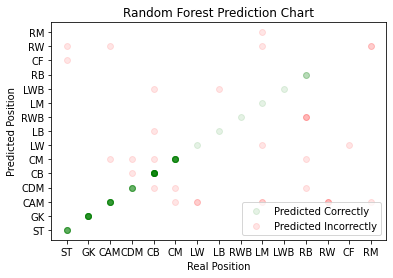

In [ ]:
# prediction graph3
y_test_correct = y_test[y_test == y_pred_forest]
y_test_incorrect = y_test[y_test != y_pred_forest]
y_pred_correct = y_pred_forest[y_test == y_pred_forest]
y_pred_incorrect = y_pred_forest[y_test != y_pred_forest]

plt.scatter(y_test_correct, y_pred_correct, color='g', alpha = .1, label = 'Predicted Correctly')
plt.scatter(y_test_incorrect, y_pred_incorrect, color='r', alpha = .1, label = 'Predicted Incorrectly')
plt.xlabel('Real Position')
plt.ylabel('Predicted Position')
plt.title('Random Forest Prediction Chart')
plt.legend()
plt.show()

<font size="6"> Part C: Club with the Best Staff </font>

In [ ]:
teams15 = list(pd.read_csv('team_data_15.csv')["Club Name"])
teams20 = list(pd.read_csv('team_data_20.csv')["Club Name"])

dfC = df.copy()
dfC = dfC[dfC['Club_20'].isin(teams20)]
dfC = dfC[dfC['Club_15'].isin(teams15)]
dfC = dfC[dfC['Club_20'] == dfC['Club_15']]
dfC2= pd.DataFrame()

league_dict = dict(zip(teams15, pd.read_csv('team_data_15.csv')["League"]))

dfC2['Club'] = dfC['Club_20']
dfC2['Age'] = dfC['Age_15']
dfC2["Overall_Change"] = dfC["Overall Rating_20"] - dfC["Overall Rating_15"]
dfC2["Value_Change"] = dfC["Value_20"] - dfC["Value_15"]
dfC2['Pace/Diving_Change'] = dfC['Pace/Diving_20'] - dfC['Pace/Diving_15']
dfC2['Shooting/Handling_Change'] = dfC['Shooting/Handling_20'] - dfC['Shooting/Handling_15']
dfC2['Passing/Kicking_Change'] = dfC['Passing/Kicking_20'] - dfC['Passing/Kicking_15']
dfC2['Dribbling/Reflexex_Change'] = dfC['Dribbling/Reflexex_20'] - dfC['Dribbling/Reflexex_15']
dfC2['Defending/Pace_Change'] = dfC['Defending/Pace_20'] - dfC['Defending/Pace_15']
dfC2['Physical/Positioning_Change'] = dfC['Physical/Positioning_20'] - dfC['Physical/Positioning_15']

dfC2 = dfC2.groupby("Club", as_index=False).mean()

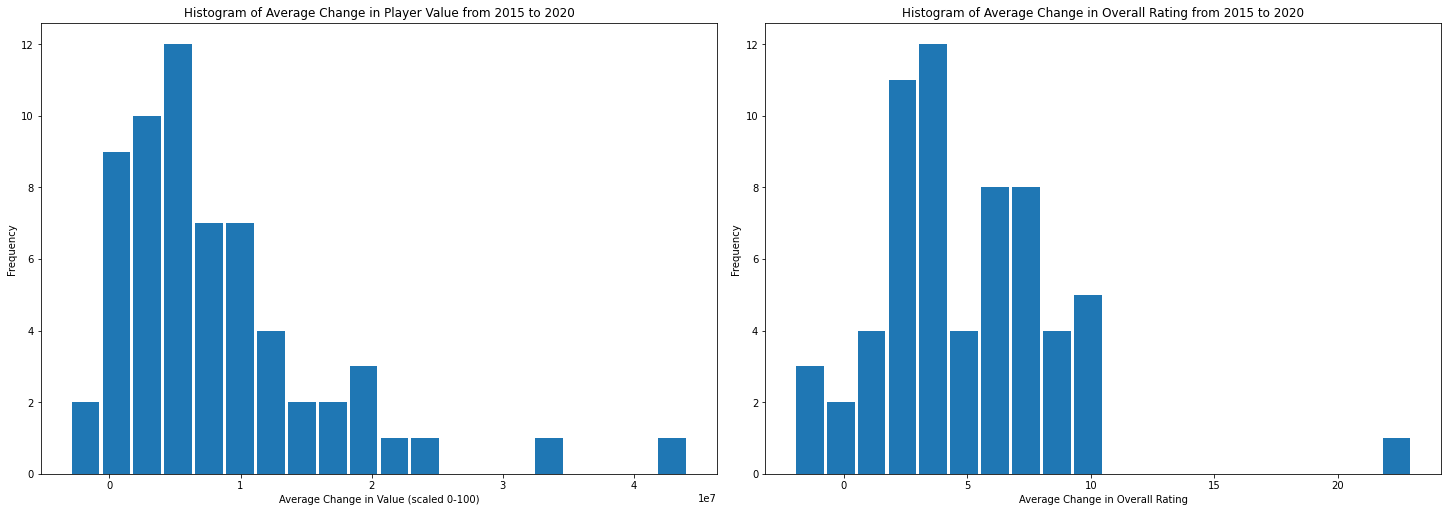

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(20,7), constrained_layout=True)
axs[0].hist(list(dfC2["Value_Change"].values), bins=20, rwidth=0.9)
axs[0].set_title("Histogram of Average Change in Player Value from 2015 to 2020")
axs[0].set_xlabel("Average Change in Value (scaled 0-100)")
axs[0].set_ylabel("Frequency")
axs[1].hist(list(dfC2["Overall_Change"].values), bins=20, rwidth=0.9)
axs[1].set_title("Histogram of Average Change in Overall Rating from 2015 to 2020")
axs[1].set_xlabel("Average Change in Overall Rating")
axs[1].set_ylabel("Frequency")
plt.show()

In [ ]:
#we need to decide on a weighting of these changes in skill ratings
#it seems logical that our overall change should be weighted more than the changes in individual skills
#since there are 6 of them, weight an increase by 1/6
overall_weight = 1
big6skill_weight = 1/6

over_change = dfC2["Overall_Change"]
big6_change = dfC2.drop(["Overall_Change", "Value_Change"], axis=1).sum(axis=1)

attr_change = (over_change * overall_weight) + (big6_change * big6skill_weight)
dfC2["Attr_Change"] = attr_change

In [ ]:
#scale our attribute and value changes to be on same scale
scaler = MinMaxScaler()
dfC2["Value_Change"] = scaler.fit_transform(dfC2["Value_Change"].values.reshape(-1,1))*100
dfC2["Attr_Change"] = scaler.fit_transform(dfC2["Attr_Change"].values.reshape(-1,1))*100

#notice we've defined value change as the change in a players numerical value
#we decided to use this and a weighted average of changes in players key metrics 
#as the two inputs to our score. We take average of thes to get a score from 0-100


#we chose to weight value changes and attribute changes equally in creating a ranking/rating
#so we take the average of our scaled data
dfC2["Total_Change"] = (dfC2["Value_Change"] + dfC2["Attr_Change"])/2

In [ ]:
#however, we have an issue: AGE CORRELATED WITH TOTAL CHANGE
#thus age is an important confounding factor that we should control for.
#Clubs with younger players on average may have higher score improvement without necessarily being better at training
#because younger players tend to improve while older players tend to get worse with time.
#So, we need to run a regression of "total_change" on "age" and use residuals to give us a score CONDITIONAL ON AGE

lreg = LinearRegression(fit_intercept=True)
lreg.fit(dfC2["Age"].values.reshape(-1,1), dfC2["Total_Change"].values.reshape(-1,1))
y_pred = lreg.predict(dfC2["Age"].values.reshape(-1,1))
residuals = dfC2["Total_Change"] - y_pred[0]
dfC2["Relative Performance"] = residuals
''
#relative peformance gives us how a club's players improved relative to their expected improvement given the age of the club's players

''

In [ ]:
print(f"Our regression has a coefficient of {lreg.coef_[0][0]:.3} meaning that age is negatively correlated with total change. The older the player the less improvement.")

Our regression has a coefficient of -2.07 meaning that age is negatively correlated with total change. The older the player the less improvement.


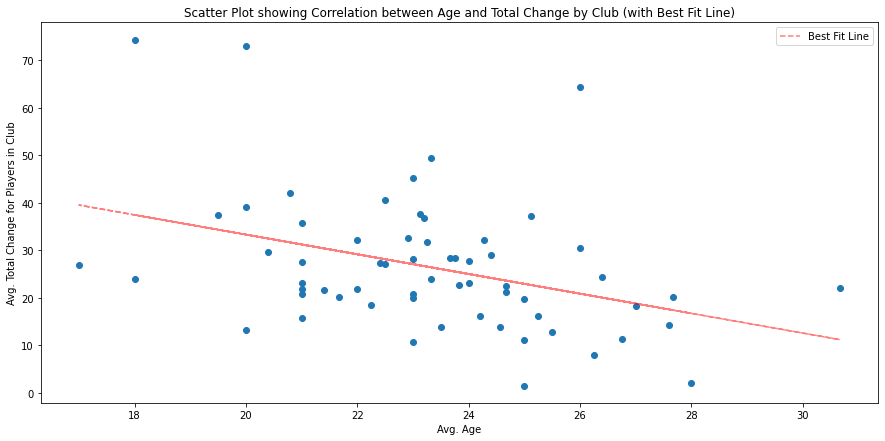

In [ ]:
#this graph shows the correlation between age and total_change that motivated the above regression
plt.figure(figsize=(15,7))
plt.scatter(dfC2["Age"], dfC2["Total_Change"])
plt.plot(dfC2["Age"], y_pred, 'r', linestyle='--', alpha=0.5, label="Best Fit Line")
plt.xlabel("Avg. Age")
plt.ylabel("Avg. Total Change for Players in Club")
plt.title("Scatter Plot showing Correlation between Age and Total Change by Club (with Best Fit Line)")
plt.legend()
plt.show()

In [ ]:
#rank based on realtive performance
dfC2['Rank'] = dfC2['Relative Performance'].rank(ascending = False).astype(int)

In [ ]:
#convert relative performace to scaled
scaler2 = StandardScaler()
dfC2["Scaled Performance"] = scaler2.fit_transform(dfC2["Relative Performance"].values.reshape(-1,1))
dfC2["Scaled Performance"] = dfC2["Scaled Performance"] * 10 + 50 #set mean score to 50 and std deviation 10
dfC2["Score"] = dfC2["Scaled Performance"].astype(int)

In [ ]:
dfCfinal = dfC2[["Club", "Rank", 'Score']]
dfCfinal["League"] = [league_dict[club][1:] for club in dfC2['Club']]
print("The 5 Clubs with the Best Staff are:")
dfCfinal.sort_values(by="Rank").head()

The 5 Clubs with the Best Staff are:
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Club,Rank,Score,League
47,Roma,1,84,Italian Serie A
9,Atlético de Madrid,2,83,Spain Primera Division
7,Atalanta,3,77,Italian Serie A
37,Napoli,4,66,Italian Serie A
42,Paris Saint-Germain,5,63,French Ligue 1


In [ ]:
print("The 5 Clubs with the Worst Staff according to this model are:")
dfCfinal.sort_values(by="Rank").tail()

The 5 Clubs with the Worst Staff according to this model are:


,Club,Rank,Score,League
24,Fiorentina,58,39,Italian Serie A
38,Newcastle United,59,38,English Premier League
11,Borussia Dortmund,60,36,German 1. Bundesliga
48,SC Paderborn 07,61,32,German 1. Bundesliga
18,Everton,62,32,English Premier League


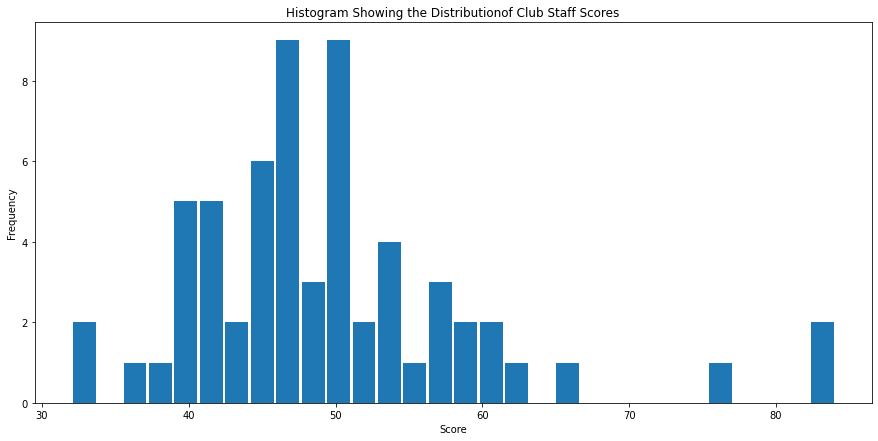

In [ ]:
#let's inspect how our scores are distributed
plt.figure(figsize=(15,7))
plt.hist(list(dfCfinal["Score"].values), bins=30, rwidth=0.9)
plt.title("Histogram Showing the Distributionof Club Staff Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

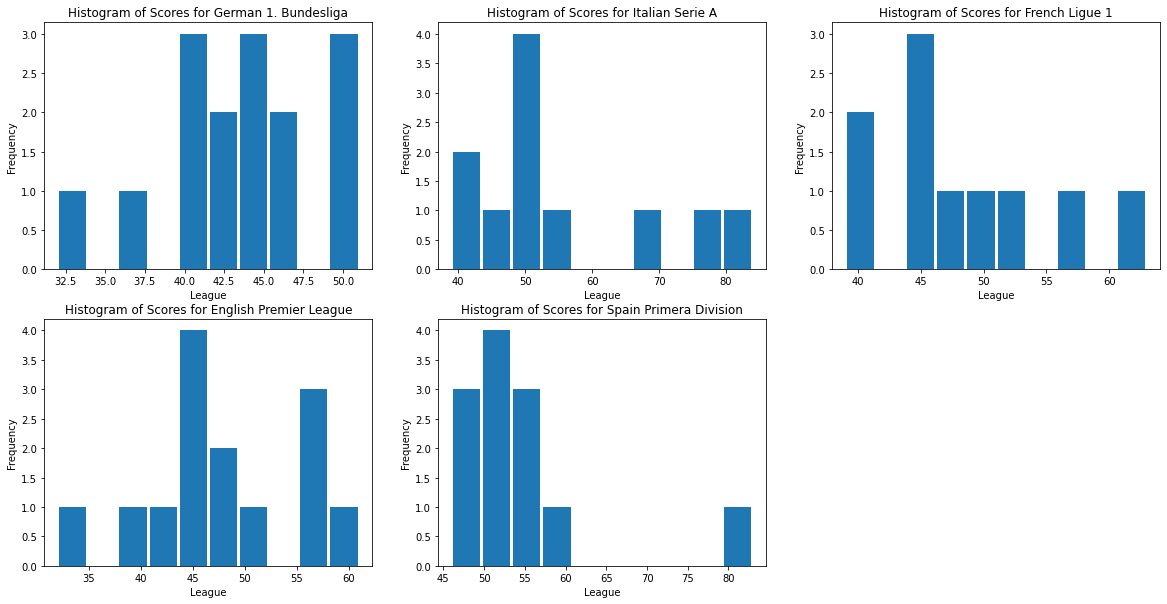

In [ ]:
#inspect scores for each league
leagues = list(dfCfinal["League"].unique())


fig, axs = plt.subplots(2,3, figsize=(20,10))

for i in range(len(leagues)):
    axs[int(i/3)][i%3].hist(list(dfCfinal[dfCfinal["League"]==leagues[i]]["Score"].values), rwidth=0.9)
    axs[int(i/3)][i%3].set_xlabel('League')
    axs[int(i/3)][i%3].set_ylabel('Frequency')
    axs[int(i/3)][i%3].set_title(f"Histogram of Scores for {leagues[i]}")

fig.delaxes(axs[1][2])
plt.show()

['Spain Primera Division', 'Italian Serie A', 'French Ligue 1', 'English Premier League', 'German 1. Bundesliga']


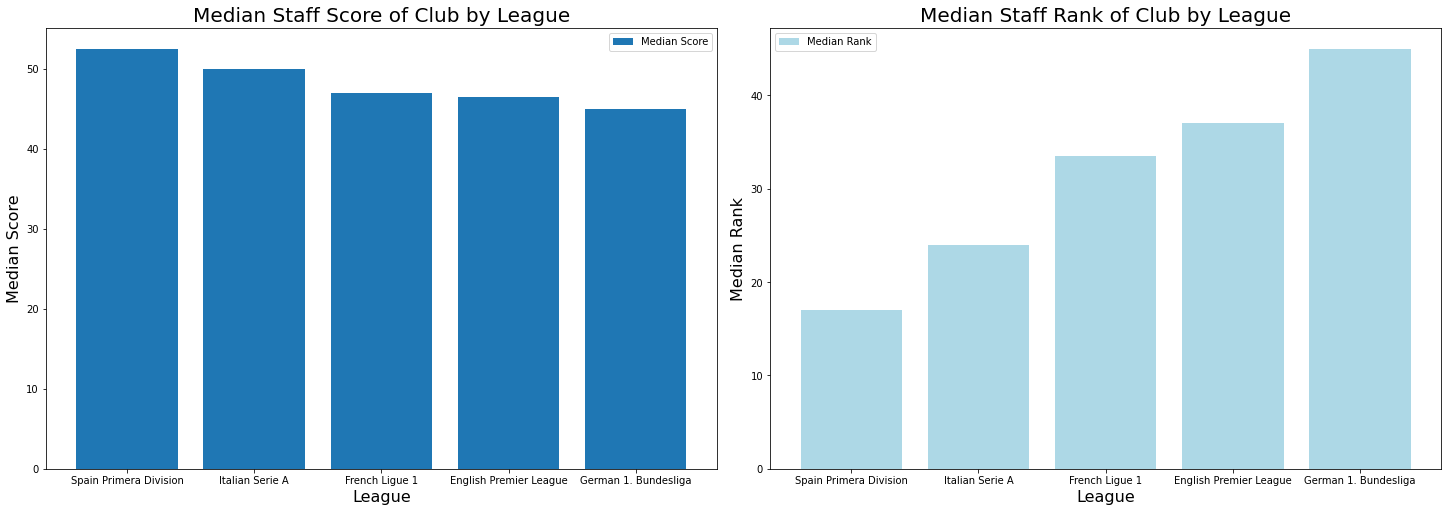

In [ ]:
grouped = dfCfinal.groupby("League").median().sort_values(by="Rank")
league_names = list(grouped.index)
print(league_names)
fig, axs = plt.subplots(1,2, figsize=(20,7), constrained_layout=True)


axs[0].bar(league_names, grouped["Score"] ,label="Median Score")
axs[1].bar(league_names, grouped["Rank"], label="Median Rank", color='lightblue')

axs[0].set_xlabel('League', fontsize=16)
axs[0].set_ylabel('Median Score', fontsize=16)
axs[1].set_xlabel('League', fontsize=16)
axs[1].set_ylabel('Median Rank', fontsize=16)
axs[0].set_title("Median Staff Score of Club by League", fontsize=20)
axs[1].set_title("Median Staff Rank of Club by League", fontsize=20)

axs[0].legend()
axs[1].legend()
plt.show()

<font size="6"> Part D: How will things be in 2021? </font>

In [ ]:
teams20 = pd.read_csv('team_data_20.csv')
teams20list = teams20['Club Name'].tolist()
teams15 = pd.read_csv('team_data_15.csv')
teams15list = teams15['Club Name'].tolist()

teams1520list = teams20list + teams15list

# read the data from the CSV to use in part D

df_part_d = pd.read_csv("player_data.csv")

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3173: DtypeWarning: Columns (16,19,113,116,306,307,310,497) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# specifying the predictors and outcome variables to be used in x_train, y_train, x_test, and y_test
x_train_years = ['_19']
y_train_years = ['_19']
x_test_years = ['_20']
y_test_years = ['_20']

pace_predictors = ['Acceleration','Sprint Speed','Agility','Reactions']
shooting_predictors = ['Finishing', 'Heading Accuracy', 'Volleys', 'FK Accuracy', 'Curve','Shot Power',]
passing_predictors = ['Crossing', 'Short Passing','Curve','FK Accuracy','Long Passing','Ball Control','Vision']
dribbling_predictors = ['Skill Moves','Dribbling','Ball Control','Agility','Reactions','Balance',]
defense_predictors = ['Aggression','Interceptions','Positioning','Vision', 'Defensive Awareness / Marking','Standing Tackle','Sliding Tackle']
physical_predictors = ['Balance','Shot Power','Aggression','Jumping','Stamina','Strength']

part_d_predictors = [pace_predictors, shooting_predictors, passing_predictors, dribbling_predictors, defense_predictors, physical_predictors]

main_six = ['Pace','Shooting','Passing','Dribbling','Defending','Physical']


In [ ]:
# creating x_train dataframes (there are six, one for each main skill in the main_six list)
x_train_Pace = pd.DataFrame()
x_train_Shooting = pd.DataFrame()
x_train_Passing = pd.DataFrame()
x_train_Dribbling = pd.DataFrame()
x_train_Defending = pd.DataFrame()
x_train_Physical = pd.DataFrame()

In [ ]:
# populate the 6 x_train dataframes

# populate the x_train_Pace dataframe
for predictor in pace_predictors:
    x_train_Pace[predictor] = df_part_d[predictor + '_19']

# populate the x_train_Shooting dataframe
for predictor in shooting_predictors:
    x_train_Shooting[predictor] = df_part_d[predictor + '_19']

# populate the x_train_Passing dataframe
for predictor in passing_predictors:
    x_train_Passing[predictor] = df_part_d[predictor + '_19']

# populate the x_train_Dribbling dataframe
for predictor in dribbling_predictors:
    x_train_Dribbling[predictor] = df_part_d[predictor + '_19']

# populate the x_train_Defending dataframe
for predictor in defense_predictors:
    x_train_Defending[predictor] = df_part_d[predictor + '_19']

# populate the x_train_Physical dataframe
for predictor in physical_predictors:
    x_train_Physical[predictor] = df_part_d[predictor + '_19']

In [ ]:
# initialize the y_train dataframes
y_train_Pace = pd.DataFrame()
y_train_Shooting = pd.DataFrame()
y_train_Passing = pd.DataFrame()
y_train_Dribbling = pd.DataFrame()
y_train_Defending = pd.DataFrame()
y_train_Physical = pd.DataFrame()

In [ ]:
# populate the y_train dataframes

y_train_Pace = df_part_d['Pace/Diving_19']
y_train_Shooting = df_part_d['Shooting/Handling_19']
y_train_Passing = df_part_d['Passing/Kicking_19']
y_train_Dribbling = df_part_d['Dribbling/Reflexex_19']
y_train_Defending = df_part_d['Defending/Pace_19']
y_train_Physical = df_part_d['Physical/Positioning_19']

In [ ]:
# initialize x_test dataframes

x_test_Pace = pd.DataFrame()
x_test_Shooting = pd.DataFrame()
x_test_Passing = pd.DataFrame()
x_test_Dribbling = pd.DataFrame()
x_test_Defending = pd.DataFrame()
x_test_Physical = pd.DataFrame()

In [ ]:
# populate x_test dataframes

# populate the x_test_Pace dataframe
for predictor in pace_predictors:
    x_test_Pace[predictor] = df_part_d[predictor + '_20']

# populate the x_train_Shooting dataframe
for predictor in shooting_predictors:
    x_test_Shooting[predictor] = df_part_d[predictor + '_20']

# populate the x_train_Passing dataframe
for predictor in passing_predictors:
    x_test_Passing[predictor] = df_part_d[predictor + '_20']

# populate the x_train_Dribbling dataframe
for predictor in dribbling_predictors:
    x_test_Dribbling[predictor] = df_part_d[predictor + '_20']

# populate the x_train_Defending dataframe
for predictor in defense_predictors:
    x_test_Defending[predictor] = df_part_d[predictor + '_20']

# populate the x_train_Physical dataframe
for predictor in physical_predictors:
    x_test_Physical[predictor] = df_part_d[predictor + '_20']


In [ ]:
# initialize y_test dataframes
y_test_Pace = pd.DataFrame()
y_test_Shooting = pd.DataFrame()
y_test_Passing = pd.DataFrame()
y_test_Dribbling = pd.DataFrame()
y_test_Defending = pd.DataFrame()
y_test_Physical = pd.DataFrame()

In [ ]:
# populate y_test dataframes
y_test_Pace = df_part_d['Pace/Diving_20']
y_test_Shooting = df_part_d['Shooting/Handling_20']
y_test_Passing = df_part_d['Passing/Kicking_20']
y_test_Dribbling = df_part_d['Dribbling/Reflexex_20']
y_test_Defending = df_part_d['Defending/Pace_20']
y_test_Physical = df_part_d['Physical/Positioning_20']

In [ ]:
# For Pace, initialize a linear regression model, fit it to the training data, and calculate train and test MSE
# Also add train MSE, test MSE, and test R-squared to lists

from sklearn.metrics import r2_score

linreg = LinearRegression().fit(x_train_Pace, y_train_Pace)
y_train_pred = linreg.predict(x_train_Pace)
y_test_pred = linreg.predict(x_test_Pace)

train_mse = mean_squared_error(y_train_Pace, y_train_pred)
test_mse = mean_squared_error(y_test_Pace, y_test_pred)

print("Linear regression model results for player Pace rating:\n")
print(
    "\tTrain MSE\t{:.4f}\n"
    "\tTest MSE\t{:.4f}\n".format(
        train_mse,
        test_mse,
    )
)

#Compute the R-squared of the model
r2 = r2_score(y_test_Pace, y_test_pred)
print(f"\tTest R-squared\t{r2:.4f}")

r2_list = []
r2_list.append(r2)
train_MSE_list = []
test_MSE_list = []
train_MSE_list.append(train_mse)
test_MSE_list.append(test_mse)

Linear regression model results for player Pace rating:

	Train MSE	55.0418
	Test MSE	58.2352

	Test R-squared	0.6175


In [ ]:
# For Shooting, initialize a linear regression model, fit it to the training data, and calculate train and test MSE
# Also add train MSE, test MSE, and test R-squared to lists

linreg = LinearRegression().fit(x_train_Shooting, y_train_Shooting)
y_train_pred = linreg.predict(x_train_Shooting)
y_test_pred = linreg.predict(x_test_Shooting)

train_mse = mean_squared_error(y_train_Shooting, y_train_pred)
test_mse = mean_squared_error(y_test_Shooting, y_test_pred)

print("Linear regression model results for player Shooting rating:\n")
print(
    "\tTrain MSE\t{:.4f}\n"
    "\tTest MSE\t{:.4f}\n".format(
        train_mse,
        test_mse,
    )
)

#Compute the R-squared of the model
r2 = r2_score(y_test_Shooting, y_test_pred)
print(f"\tTest R-squared\t{r2:.4f}")

train_MSE_list.append(train_mse)
test_MSE_list.append(test_mse)
r2_list.append(r2)

Linear regression model results for player Shooting rating:

	Train MSE	61.3740
	Test MSE	51.0345

	Test R-squared	0.7267


In [ ]:
# For Passing, initialize a linear regression model, fit it to the training data, and calculate train and test MSE
# Also add train MSE, test MSE, and test R-squared to lists

linreg = LinearRegression().fit(x_train_Passing, y_train_Passing)
y_train_pred = linreg.predict(x_train_Passing)
y_test_pred = linreg.predict(x_test_Passing)

train_mse = mean_squared_error(y_train_Passing, y_train_pred)
test_mse = mean_squared_error(y_test_Passing, y_test_pred)

print("Linear regression model results for player Passing rating:\n")
print(
    "\tTrain MSE\t{:.4f}\n"
    "\tTest MSE\t{:.4f}\n".format(
        train_mse,
        test_mse,
    )
)

#Compute the R-squared of the model
r2 = r2_score(y_test_Passing, y_test_pred)
print(f"\tTest R-squared\t{r2:.4f}")

train_MSE_list.append(train_mse)
test_MSE_list.append(test_mse)
r2_list.append(r2)

Linear regression model results for player Passing rating:

	Train MSE	30.2945
	Test MSE	29.6964

	Test R-squared	0.6504


In [ ]:
# For Dribbling, initialize a linear regression model, fit it to the training data, and calculate train and test MSE
# Also add train MSE, test MSE, and test R-squared to lists

linreg = LinearRegression().fit(x_train_Dribbling, y_train_Dribbling)
y_train_pred = linreg.predict(x_train_Dribbling)
y_test_pred = linreg.predict(x_test_Dribbling)

train_mse = mean_squared_error(y_train_Dribbling, y_train_pred)
test_mse = mean_squared_error(y_test_Dribbling, y_test_pred)

print("Linear regression model results for player Dribbling rating:\n")
print(
    "\tTrain MSE\t{:.4f}\n"
    "\tTest MSE\t{:.4f}\n".format(
        train_mse,
        test_mse,
    )
)

#Compute the R-squared of the model
r2 = r2_score(y_test_Dribbling, y_test_pred)
print(f"\tTest R-squared\t{r2:.4f}")

train_MSE_list.append(train_mse)
test_MSE_list.append(test_mse)
r2_list.append(r2)

Linear regression model results for player Dribbling rating:

	Train MSE	36.2227
	Test MSE	34.9818

	Test R-squared	0.6186


In [ ]:
# For Defending, initialize a linear regression model, fit it to the training data, and calculate train and test MSE
# Also add train MSE, test MSE, and test R-squared to lists

linreg = LinearRegression().fit(x_train_Defending, y_train_Defending)
y_train_pred = linreg.predict(x_train_Defending)
y_test_pred = linreg.predict(x_test_Defending)

train_mse = mean_squared_error(y_train_Defending, y_train_pred)
test_mse = mean_squared_error(y_test_Defending, y_test_pred)

print("Linear regression model results for player Defending rating:\n")
print(
    "\tTrain MSE\t{:.4f}\n"
    "\tTest MSE\t{:.4f}\n".format(
        train_mse,
        test_mse,
    )
)

#Compute the R-squared of the model
r2 = r2_score(y_test_Defending, y_test_pred)
print(f"\tTest R-squared\t{r2:.4f}")

train_MSE_list.append(train_mse)
test_MSE_list.append(test_mse)
r2_list.append(r2)

Linear regression model results for player Defending rating:

	Train MSE	19.9111
	Test MSE	19.7030

	Test R-squared	0.9204


In [ ]:
# For Physical, initialize a linear regression model, fit it to the training data, and calculate train and test MSE
# Also add train MSE, test MSE, and test R-squared to lists

linreg = LinearRegression().fit(x_train_Physical, y_train_Physical)
y_train_pred = linreg.predict(x_train_Physical)
y_test_pred = linreg.predict(x_test_Physical)

train_mse = mean_squared_error(y_train_Physical, y_train_pred)
test_mse = mean_squared_error(y_test_Physical, y_test_pred)

print("Linear regression model results for player Physical rating:\n")
print(
    "\tTrain MSE\t{:.4f}\n"
    "\tTest MSE\t{:.4f}\n".format(
        train_mse,
        test_mse,
    )
)

#Compute the R-squared of the model
r2 = r2_score(y_test_Physical, y_test_pred)
print(f"\tTest R-squared\t{r2:.4f}")

train_MSE_list.append(train_mse)
test_MSE_list.append(test_mse)
r2_list.append(r2)

Linear regression model results for player Physical rating:

	Train MSE	15.2139
	Test MSE	19.1280

	Test R-squared	0.6678


Text(0, 0.5, 'Train MSE')

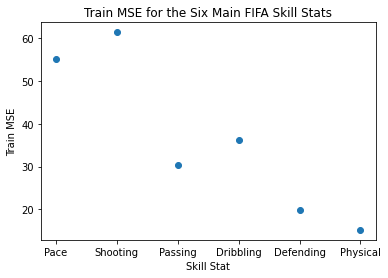

In [ ]:
plt.scatter(main_six, train_MSE_list)
plt.title('Train MSE for the Six Main FIFA Skill Stats')
plt.xlabel('Skill Stat')
plt.ylabel('Train MSE')

Text(0, 0.5, 'Test MSE')

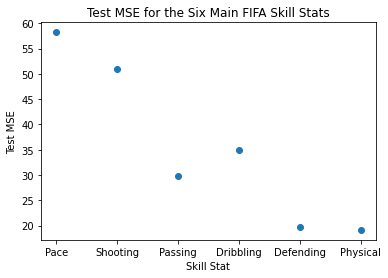

In [ ]:
plt.scatter(main_six, test_MSE_list)
plt.title('Test MSE for the Six Main FIFA Skill Stats')
plt.xlabel('Skill Stat')
plt.ylabel('Test MSE')

Text(0, 0.5, 'R-squared Value')

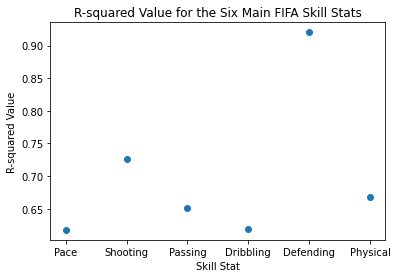

In [ ]:
plt.scatter(main_six, r2_list)
plt.title('R-squared Value for the Six Main FIFA Skill Stats')
plt.xlabel('Skill Stat')
plt.ylabel('R-squared Value')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=85066ebd-6398-46be-9f54-4417b0e5b6c0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>